379.2079207920792
69
7720.79207920792
69


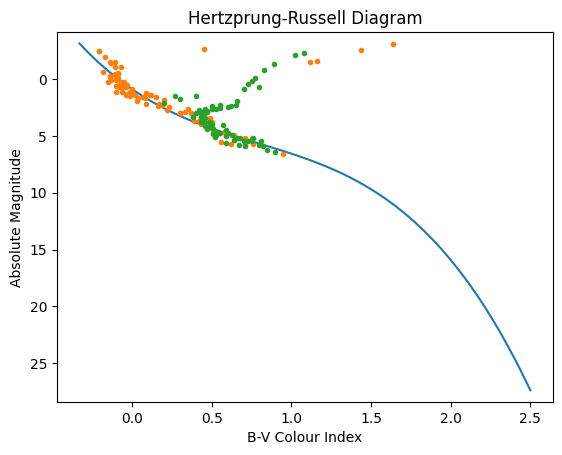

In [85]:
import numpy as np;
from matplotlib import pyplot as mpl;
import pandas as pd;

# Note, saved as csv and removed the titles of the commons
NGC2516 = pd.read_csv("NGC2516.csv", sep = ",", names = ["(B-V) Colour Index", "Apparent Visual Magnitude V"]);
NGC3201 = pd.read_csv("NGC3201.csv", sep = ",", names = ["(B-V) Colour Index", "Apparent Visual Magnitude V"]);

bv = np.linspace(-0.33, 2.5, 10000);
def absoluteMagnitudeFromColourIndex(bv):
    return 0.89 + 9.61 * bv - 6.83 * np.power(bv, 2) + 2.89 * np.power(bv, 3);

def absoluteMagnitudeFromDistance(apparentMagnitudes, distance):
    absoluteMagnitudes = [];

    for apparentMagnitude in apparentMagnitudes:
        absoluteMagnitudes.append(apparentMagnitude - 5 * (np.log10(distance) - 1));

    return absoluteMagnitudes;

absoluteMagnitudePlot = absoluteMagnitudeFromColourIndex(bv);

mpl.plot(bv, absoluteMagnitudePlot);
mpl.ylim(max(absoluteMagnitudePlot) + 1, min(absoluteMagnitudePlot) - 1);

d1 = 0.12;
d2 = 0.20;

def findSigmasForEachAbsoluteMagnitude(bv, apparentMagnitudes):
    distanceLowerBound = 100;
    distanceUpperBound = 10000;
    distanceIntervals = 10000;

    distance = np.linspace(distanceLowerBound, distanceUpperBound, distanceIntervals);
    absoluteMagnitudesFromDistances = absoluteMagnitudeFromDistance(apparentMagnitudes, distance);

    sigmasForEachAbsoluteMagnitude = [];
      
    for i in range(0, len(absoluteMagnitudesFromDistances)):
         sigmasForEachAbsoluteMagnitude.append(np.abs(absoluteMagnitudesFromDistances[i] - absoluteMagnitudeFromColourIndex(bv[i])));

    sigmasForEachAbsoluteMagnitude = np.array(sigmasForEachAbsoluteMagnitude);
    return sigmasForEachAbsoluteMagnitude, distance;

def fitPointsToHRDiagramUsingSigmaMethod(bv, apparentMagnitudes):
    sigmasForEachAbsoluteMagnitude, distance = findSigmasForEachAbsoluteMagnitude(bv, apparentMagnitudes);

    totalSigmaForEachDistance = [];

    for i in range(0, len(sigmasForEachAbsoluteMagnitude[0])):
        totalSigmaForEachDistance.append(sum(sigmasForEachAbsoluteMagnitude[:, i]));

    bestDistance = distance[totalSigmaForEachDistance.index(min(totalSigmaForEachDistance))];

    return bestDistance, distance, totalSigmaForEachDistance, sigmasForEachAbsoluteMagnitude[:, totalSigmaForEachDistance.index(min(totalSigmaForEachDistance))];
        

def fitPointsToMainSequenceUsingPointsInRangeMethod(bv, apparentMagnitudes, arbitraryCutoff = 2.5):
    # Distance is defined but not used as both are returned
    sigmasForEachAbsoluteMagnitude, distance = findSigmasForEachAbsoluteMagnitude(bv, apparentMagnitudes);

    sigmasForEachDistance = [];

    for i in range(0, len(sigmasForEachAbsoluteMagnitude[0])):
        sigmasForEachDistance.append(sigmasForEachAbsoluteMagnitude[:, i]);

    maximumPointsInRange = 0;
    removedIndexes = [];
    bestDistance = 0;

    count = 0;
    for sigmasForADistance in sigmasForEachDistance:
        pointsInRange = 0;
        currentRemovedIndexes = [];

        for sigmaForADistance in sigmasForADistance: 
            if (sigmaForADistance <  arbitraryCutoff):
                pointsInRange += 1;
            else:
                currentRemovedIndexes.append(np.ndarray.tolist(sigmasForADistance).index(sigmaForADistance));

        if (pointsInRange > maximumPointsInRange):
            maximumPointsInRange = pointsInRange;
            removedIndexes = currentRemovedIndexes;
            bestDistance = distance[count];

        count += 1;
            
    return removedIndexes, bestDistance;

def fitPointsToMainSequence(bv, apparentMagnitudes, arbitraryCutoff = 2.5):
    outlierDataIndexes, bestDistance = fitPointsToMainSequenceUsingPointsInRangeMethod(bv, apparentMagnitudes, 0.1);

    # Repeated code but shut
    # To remove items at indexes, they need to be lists, but they can't directly turn into lists
    bv = np.array(bv);
    apparentMagnitudes = np.array(apparentMagnitudes);
    bv = np.ndarray.tolist(bv);
    apparentMagnitudes = np.ndarray.tolist(apparentMagnitudes);

    count = 0;
    for outlierDataIndex in outlierDataIndexes:
        bv.pop(outlierDataIndex - count);
        apparentMagnitudes.pop(outlierDataIndex - count);
        count += 1;

    bv = np.array(bv);
    apparentMagnitudes = np.array(apparentMagnitudes);

    fitData = fitPointsToHRDiagramUsingSigmaMethod(bv, apparentMagnitudes);
    print(bestDistance);
    print(len(outlierDataIndexes));
    #print(fitData[0])

    #return bestDistance;
    return fitData[0], fitData[1], fitData[2];
    
    # Basically everything past here is unnecessary as the method prior to this works significantly better #
    # Remember to code the option past here as an additional option

    outlierDataIndexes = [];

    for i in range(0, len(fitData[3])):
        if fitData[3][i] >= arbitraryCutoff:
            outlierDataIndexes.append(i);

    # To remove items at indexes, they need to be lists, but they can't directly turn into lists
    bv = np.array(bv);
    apparentMagnitudes = np.array(apparentMagnitudes);
    bv = np.ndarray.tolist(bv);
    apparentMagnitudes = np.ndarray.tolist(apparentMagnitudes);

    count = 0;
    for outlierDataIndex in outlierDataIndexes:
        bv.pop(outlierDataIndex - count);
        apparentMagnitudes.pop(outlierDataIndex - count);
        count += 1;

    bv = np.array(bv);
    apparentMagnitudes = np.array(apparentMagnitudes);

    trueFitData = fitPointsToHRDiagram(bv, apparentMagnitudes);

    return trueFitData[0], trueFitData[1], trueFitData[2], len(outlierDataIndexes);
    


fitData1 = fitPointsToMainSequence(NGC2516["(B-V) Colour Index"] - d1, NGC2516["Apparent Visual Magnitude V"] - 3 * d1);
#fitData2 = fitPointsToHRDiagram(NGC2516["(B-V) Colour Index"] - d1, NGC2516["Apparent Visual Magnitude V"] - 3 * d1);
fitData3 = fitPointsToMainSequence(NGC3201["(B-V) Colour Index"] - d1, NGC3201["Apparent Visual Magnitude V"] - 3 * d1);
#fitData4 = fitPointsToHRDiagram(NGC3201["(B-V) Colour Index"] - d1, NGC3201["Apparent Visual Magnitude V"] - 3 * d1);

#print(fitData3[0])

mpl.plot(NGC2516["(B-V) Colour Index"] - d1, (NGC2516["Apparent Visual Magnitude V"] - 3 * d1) - 5 * (np.log10(fitData1[0]) - 1), ".");
#mpl.plot(NGC2516["(B-V) Colour Index"] - d1, (NGC2516["Apparent Visual Magnitude V"] - 3 * d1) - 5 * (np.log10(fitData2) - 1), ".");
mpl.plot(NGC3201["(B-V) Colour Index"] - d2, (NGC3201["Apparent Visual Magnitude V"] - 3 * d2) - 5 * (np.log10(fitData3[0]) - 1), ".");
#mpl.plot(NGC3201["(B-V) Colour Index"] - d2, (NGC3201["Apparent Visual Magnitude V"] - 3 * d2) - 5 * (np.log10(fitData4) - 1), ".");

mpl.xlabel("B-V Colour Index");
mpl.ylabel("Absolute Magnitude");
mpl.title("Hertzprung-Russell Diagram");

mpl.show();

#mpl.plot(fitData1[1], fitData1[2], label = "Cluster 1");
#mpl.plot(fitData3[1], fitData3[2], label = "Cluster 2");

#mpl.legend();
#mpl.xlabel("Distance");
#mpl.ylabel("Sigma");

#mpl.show();

284.15841584158414
6612.8712871287125


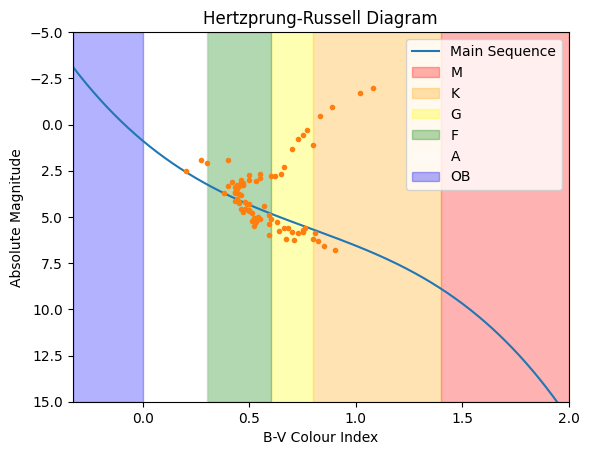

In [36]:
import numpy as np;
from matplotlib import pyplot as mpl;
import pandas as pd;

# Note, saved as csv and removed the titles of the commons
NGC2516 = pd.read_csv("NGC2516.csv", sep = ",", names = ["(B-V) Colour Index", "Apparent Visual Magnitude V"]);
NGC3201 = pd.read_csv("NGC3201.csv", sep = ",", names = ["(B-V) Colour Index", "Apparent Visual Magnitude V"]);

# This defines the x axis, B-V colour index
bv = np.linspace(-0.33, 2.5, 10000);

# This defines the function that maps the b-v colour index to the main sequence line
def absoluteMagnitudeFromColourIndex(bv):
    return 0.89 + 9.61 * bv - 6.83 * np.power(bv, 2) + 2.89 * np.power(bv, 3);

absoluteMagnitudePlot = absoluteMagnitudeFromColourIndex(bv);

# This sets the graph's x and y axis limits, and displays the main sequence theoretical line
mpl.plot(bv, absoluteMagnitudePlot, label = "Main Sequence");
mpl.xlim(-0.33, 2);
mpl.ylim(15, -5);

# This defines how to convert from apparent magnitude to absolute magnitude given a star's distance
def absoluteMagnitudeFromDistance(apparentMagnitudes, distance):
    absoluteMagnitudes = [];

    for apparentMagnitude in apparentMagnitudes:
        absoluteMagnitudes.append(apparentMagnitude - 5 * (np.log10(distance) - 1));

    return absoluteMagnitudes;

# This function takes the inputted colour indexes and apparent magnitudes and removes the stars at the given outlier indexes
# This is used to remove non-main-sequence stars during fitting clusters to the main sequence
def removeOutliers(bv, apparentMagnitudes, outlierDataIndexes):
    # To remove items at indexes, they need to be lists, but they can't directly turn into lists
    bv = np.array(bv);
    apparentMagnitudes = np.array(apparentMagnitudes);
    bv = np.ndarray.tolist(bv);
    apparentMagnitudes = np.ndarray.tolist(apparentMagnitudes);

    count = 0;
    for outlierDataIndex in outlierDataIndexes:
        bv.pop(outlierDataIndex - count);
        apparentMagnitudes.pop(outlierDataIndex - count);
        count += 1;

    return bv, apparentMagnitudes;

# This function takes the star data and for a range of distances provides an error value, called sigma
# This error is equal to the absolute vertical displacement each star point is from the main sequence line
def findSigmasForEachAbsoluteMagnitude(bv, apparentMagnitudes, distanceLowerBound = 100, distanceUpperBound = 10000, distanceIntervals = 10000):
    distance = np.linspace(distanceLowerBound, distanceUpperBound, distanceIntervals);
    absoluteMagnitudesFromDistances = absoluteMagnitudeFromDistance(apparentMagnitudes, distance);

    sigmasForEachAbsoluteMagnitude = [];
      
    for i in range(0, len(absoluteMagnitudesFromDistances)):
         sigmasForEachAbsoluteMagnitude.append(np.abs(absoluteMagnitudesFromDistances[i] - absoluteMagnitudeFromColourIndex(bv[i])));

    sigmasForEachAbsoluteMagnitude = np.array(sigmasForEachAbsoluteMagnitude);
    return sigmasForEachAbsoluteMagnitude, distance;

# This function takes calculated error values for every data point at every distance and finds the distance that the sum of the errors is at it's minimum
# This in hence fits the stars to the main sequence line by finding the distance where the error from being perfectly matching is smallest
def fitPointsToHRDiagramUsingSigmaMethod(bv, apparentMagnitudes):
    sigmasForEachAbsoluteMagnitude, distance = findSigmasForEachAbsoluteMagnitude(bv, apparentMagnitudes);

    totalSigmaForEachDistance = [];

    for i in range(0, len(sigmasForEachAbsoluteMagnitude[0])):
        totalSigmaForEachDistance.append(sum(sigmasForEachAbsoluteMagnitude[:, i]));

    bestDistance = distance[totalSigmaForEachDistance.index(min(totalSigmaForEachDistance))];

    return bestDistance, distance, totalSigmaForEachDistance, sigmasForEachAbsoluteMagnitude[:, totalSigmaForEachDistance.index(min(totalSigmaForEachDistance))];

# This function fits the data to the line twice using the sigma method
# After the first time, data points that seem too far out from the main sequence line are removed
# Assuming most data points fit the main sequence, this method should accurately remove outliers like gas giants and hence provide a more accurate fit
def fitPointsToMainSequenceUsingSigmaMethod(bv, apparentMagnitudes, arbitraryCutoff = 2.5):
    fitData = fitPointsToHRDiagramUsingSigmaMethod(bv, apparentMagnitudes);

    outlierDataIndexes = [];

    for i in range(0, len(fitData[3])):
        if fitData[3][i] >= arbitraryCutoff:
            outlierDataIndexes.append(i);

    bv, apparentMagnitudes = removeOutliers(bv, apparentMagnitudes, outlierDataIndexes);

    trueFitData = fitPointsToHRDiagramUsingSigmaMethod(bv, apparentMagnitudes);

    return trueFitData[0];

#, trueFitData[1], trueFitData[2], len(outlierDataIndexes);      

# This function fits data that follows more than one trend line
# If lots of stars trail into being gas giants, then the sigma method would fit the data halfway in between the gas giants and the main sequence stars
# This method instead varies the distance and maximises the number of stars that appear in a tight band around the main sequence line
# As long as there are no unusually dense regions of gas giants (in comparison to main sequence stars as a whole), this method should accurately fit the data to the main sequence
def fitPointsToMainSequenceUsingPointsInRangeMethod(bv, apparentMagnitudes, arbitraryCutoff = 0.1):
    sigmasForEachAbsoluteMagnitude, distance = findSigmasForEachAbsoluteMagnitude(bv, apparentMagnitudes);

    sigmasForEachDistance = [];

    for i in range(0, len(sigmasForEachAbsoluteMagnitude[0])):
        sigmasForEachDistance.append(sigmasForEachAbsoluteMagnitude[:, i]);

    maximumPointsInRange = 0;
    bestDistance = 0;
    outlierDataIndexes = [];

    count = 0;
    for sigmasForADistance in sigmasForEachDistance:
        pointsInRange = 0;
        currentRemovedIndexes = [];

        for sigmaForADistance in sigmasForADistance: 
            if (sigmaForADistance <  arbitraryCutoff):
                pointsInRange += 1;
            else:
                currentRemovedIndexes.append(np.ndarray.tolist(sigmasForADistance).index(sigmaForADistance));

        if (pointsInRange > maximumPointsInRange):
            maximumPointsInRange = pointsInRange;
            bestDistance = distance[count];
            outlierDataIndexes = currentRemovedIndexes;

        count += 1;
    
    bv, apparentMagnitudes = removeOutliers(bv, apparentMagnitudes, outlierDataIndexes);

    bestDistance = fitPointsToHRDiagramUsingSigmaMethod(bv, apparentMagnitudes)[0];
            
    return bestDistance;

# These are the reddening factors for each data set
d1 = 0;
d2 = 0.20;

# This finds the best fit distance for each set of data
distanceNGC2516 = fitPointsToMainSequenceUsingPointsInRangeMethod(NGC2516["(B-V) Colour Index"] - d1, NGC2516["Apparent Visual Magnitude V"] - 3 * d1);
distanceNGC3201 = fitPointsToMainSequenceUsingSigmaMethod(NGC3201["(B-V) Colour Index"] - d2, NGC3201["Apparent Visual Magnitude V"] - 3 * d2);

print(distanceNGC2516);
print(distanceNGC3201);

#mpl.plot(NGC2516["(B-V) Colour Index"] - d1, (NGC2516["Apparent Visual Magnitude V"] - 3 * d1) - 5 * (np.log10(distanceNGC2516) - 1), ".");
mpl.plot(NGC3201["(B-V) Colour Index"] - d2, (NGC3201["Apparent Visual Magnitude V"] - 3 * d2) - 5 * (np.log10(distanceNGC3201) - 1), ".");

# This creates colour bands for each star classification on the graph
mpl.axvspan(1.4, 2, color = "red", label = "M", alpha = 0.3);
mpl.axvspan(0.8, 1.4, color = "orange", label = "K", alpha = 0.3);
mpl.axvspan(0.6, 0.8, color = "yellow", label = "G", alpha = 0.3);
mpl.axvspan(0.3, 0.6, color = "green", label = "F", alpha = 0.3);
mpl.axvspan(0.0, 0.3, color = "white", label = "A", alpha = 0.3);
mpl.axvspan(-0.33, 0.0, color = "blue", label = "OB", alpha = 0.3);

# Labeling the graph
mpl.xlabel("B-V Colour Index");
mpl.ylabel("Absolute Magnitude");
mpl.title("Hertzprung-Russell Diagram");
mpl.legend();

mpl.show();

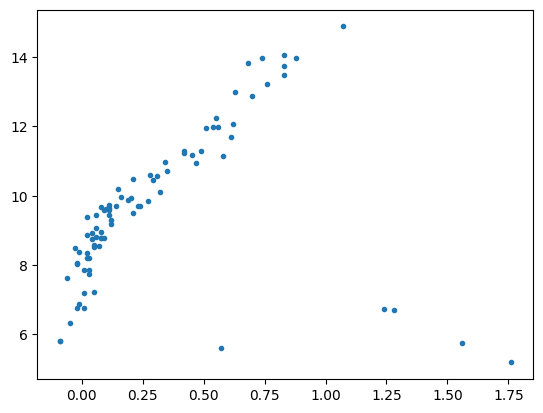

In [37]:
mpl.plot(NGC2516["(B-V) Colour Index"], NGC2516["Apparent Visual Magnitude V"], ".");

379.2079207920792
7720.79207920792


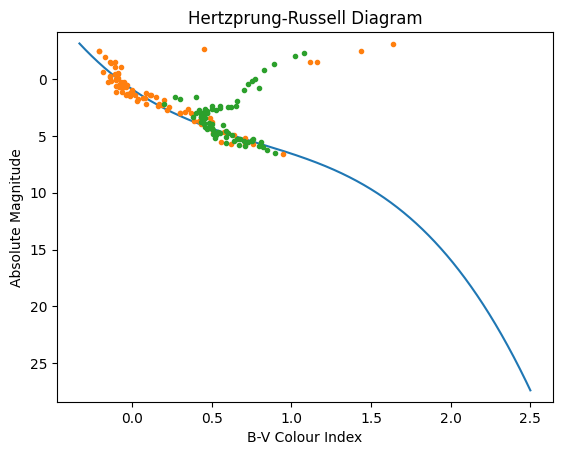

In [38]:
import numpy as np;
from matplotlib import pyplot as mpl;
import pandas as pd;

# Note, saved as csv and removed the titles of the commons
NGC2516 = pd.read_csv("NGC2516.csv", sep = ",", names = ["(B-V) Colour Index", "Apparent Visual Magnitude V"]);
NGC3201 = pd.read_csv("NGC3201.csv", sep = ",", names = ["(B-V) Colour Index", "Apparent Visual Magnitude V"]);

bv = np.linspace(-0.33, 2.5, 10000);
def absoluteMagnitudeFromColourIndex(bv):
    return 0.89 + 9.61 * bv - 6.83 * np.power(bv, 2) + 2.89 * np.power(bv, 3);

def absoluteMagnitudeFromDistance(apparentMagnitudes, distance):
    absoluteMagnitudes = [];

    for apparentMagnitude in apparentMagnitudes:
        absoluteMagnitudes.append(apparentMagnitude - 5 * (np.log10(distance) - 1));

    return absoluteMagnitudes;

absoluteMagnitudePlot = absoluteMagnitudeFromColourIndex(bv);

mpl.plot(bv, absoluteMagnitudePlot);
mpl.ylim(max(absoluteMagnitudePlot) + 1, min(absoluteMagnitudePlot) - 1);

d1 = 0.12;
d2 = 0.20;

def fitPointsToMainSequenceUsingPointsInRangeMethod(bv, apparentMagnitudes, arbitraryCutoff = 0.1):
    distanceLowerBound = 100;
    distanceUpperBound = 10000;
    distanceIntervals = 10000;

    distance = np.linspace(distanceLowerBound, distanceUpperBound, distanceIntervals);
    absoluteMagnitudesFromDistances = absoluteMagnitudeFromDistance(apparentMagnitudes, distance);

    sigmasForEachAbsoluteMagnitude = [];
      
    for i in range(0, len(absoluteMagnitudesFromDistances)):
         sigmasForEachAbsoluteMagnitude.append(np.abs(absoluteMagnitudesFromDistances[i] - absoluteMagnitudeFromColourIndex(bv[i])));

    sigmasForEachAbsoluteMagnitude = np.array(sigmasForEachAbsoluteMagnitude);

    sigmasForEachDistance = [];

    for i in range(0, len(sigmasForEachAbsoluteMagnitude[0])):
        sigmasForEachDistance.append(sigmasForEachAbsoluteMagnitude[:, i]);

    maximumPointsInRange = 0;
    bestDistance = 0;

    count = 0;
    for sigmasForADistance in sigmasForEachDistance:
        pointsInRange = 0;
        currentRemovedIndexes = [];

        for sigmaForADistance in sigmasForADistance: 
            if (sigmaForADistance <  arbitraryCutoff):
                pointsInRange += 1;
            else:
                currentRemovedIndexes.append(np.ndarray.tolist(sigmasForADistance).index(sigmaForADistance));

        if (pointsInRange > maximumPointsInRange):
            maximumPointsInRange = pointsInRange;
            bestDistance = distance[count];

        count += 1;
    
    print(bestDistance);
    return bestDistance;


distanceNGC2516 = fitPointsToMainSequenceUsingPointsInRangeMethod(NGC2516["(B-V) Colour Index"] - d1, NGC2516["Apparent Visual Magnitude V"] - 3 * d1);
distanceNGC3201 = fitPointsToMainSequenceUsingPointsInRangeMethod(NGC3201["(B-V) Colour Index"] - d1, NGC3201["Apparent Visual Magnitude V"] - 3 * d1);

mpl.plot(NGC2516["(B-V) Colour Index"] - d1, (NGC2516["Apparent Visual Magnitude V"] - 3 * d1) - 5 * (np.log10(distanceNGC2516) - 1), ".");
mpl.plot(NGC3201["(B-V) Colour Index"] - d2, (NGC3201["Apparent Visual Magnitude V"] - 3 * d2) - 5 * (np.log10(distanceNGC3201) - 1), ".");

mpl.xlabel("B-V Colour Index");
mpl.ylabel("Absolute Magnitude");
mpl.title("Hertzprung-Russell Diagram");

mpl.show();